# Lista 2

## `Questão 1`
Considere o conjunto de dados disponível em **`breastcancer.csv`**, organizado em 31 colunas, sendo as 30 primeiras colunas os atributos e a última coluna a saída. Os 30 atributos coletados de exames médicos são usados no diagnóstico do câncer de mama, sendo 1 a classe positiva e 0 a classe negativa. Maiores detalhes sobre os dados podem ser conferidos em https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset.

A) Considerando uma validação cruzada em 10 folds, avalie modelos de classicação binária nos dados em questão. Para tanto, use as abordagens
abaixo:  

- **Regressão logística** (treinado com GD ou SGD);
- **Análise do discriminante Gaussiano**;
- **Naive Bayes Gaussiano**.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import Tuple

np.random.seed(42)

In [2]:
breastcancer_data = np.loadtxt('./breastcancer.csv', delimiter=',')
breastcancer_data.shape

(569, 31)

In [3]:
def add_independent_term_column(x: np.ndarray):
    return np.hstack((np.ones((x.shape[0], 1)), x))

In [4]:
x_breastcancer_data = breastcancer_data[:, :-1]
x_breastcancer_data = add_independent_term_column(x_breastcancer_data)
x_breastcancer_data.shape

(569, 31)

In [5]:
y_breastcancer_data = breastcancer_data[:, [-1]]
y_breastcancer_data.shape

(569, 1)

### `K-Fold`

In [6]:
def kfold_split(x: np.ndarray, y: np.ndarray, n_partitions: int):
    k_folds = []

    xy = np.random.permutation(np.hstack((x, y)))

    for i in range(n_partitions):
        k_folds.append(xy[i*n_partitions : (i+1)*n_partitions, :])

    return np.array(k_folds, dtype="object")

def loo_split(x: np.ndarray, y: np.ndarray):
    return kfold_split(x, y, x.shape[0])

### `GD - Gradiente Descendente`

In [7]:
def log_func(value: float):
    return 1 / (1 + np.exp(-value))

In [8]:
def binary_cross_entropy(x: np.ndarray, w: np.ndarray, y: np.ndarray):
    noise = 1e-15
    y_pred = np.maximum(np.minimum(x @ w, 1 - noise), noise)

    return (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()

In [9]:
# Gradiente descendente
def gd_log(x: np.ndarray, y: np.ndarray, alpha: float = 0.001, max_iterations: int = 100000, stopping_error: float = 1e-10):
    # Importando features e saídas
    X = x.copy()
    Y = y.copy()

    # Inicializando os pesos
    w_gd = np.zeros((X.shape[1], 1))

    errors_list_gd = np.empty((max_iterations, X.shape[0]))
    cross_loss_list_gd = []

    # Gradiente descendente
    for iter in range(max_iterations):

        # Calculando o erro
        pred_gd = log_func(X @ w_gd)
        error_gd = Y - pred_gd
        
        # w_gd[0] = w_gd[0] + alpha * error_gd.mean(axis = 0)
        # w_gd[1:] = w_gd[1:] + alpha * (X[:,1:].T @ error_gd) / X.shape[0]
        w_gd = w_gd + alpha * (X.T @ error_gd) / X.shape[0]

        # Calculando e registrando a cross entropia binária
        cross_loss_list_gd.append(binary_cross_entropy(X, w_gd, Y))

        # Parar caso o erro esteja abaixo do mínimo aceitável
        # if(cross_loss_list_gd[iter] < stopping_error):
        #     print(f'GD encerrado precocemente pois os erros estão baixos o suficiente')
        #     break
    
    return w_gd, cross_loss_list_gd

In [10]:
w_breastcancer_data_gd_log, cross_loss_list_gd_log = gd_log(x_breastcancer_data, y_breastcancer_data, alpha=0.01, max_iterations=100000)

/var/folders/tc/mq592t7x67qbgfpvnk8cgrd80000gn/T/ipykernel_65042/745459150.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-value))


#### Parâmetros do modelo e **MSE (Erro Quadrático Médio)** final obitidos pelo algoritmo

In [11]:
np.set_printoptions(precision=8, suppress=True)
w_breastcancer_data_gd_log

array([[ -4.05129661],
       [-29.38127578],
       [ -3.75771233],
       [-71.55096879],
       [ -0.02619609],
       [  0.54463693],
       [  3.21413288],
       [  4.69033744],
       [  1.88547635],
       [  0.85164774],
       [  0.15133223],
       [ -0.71838617],
       [ -3.46274753],
       [  7.96352633],
       [ 10.11467102],
       [  0.07516133],
       [  0.76806003],
       [  1.05663293],
       [  0.25377747],
       [  0.20763119],
       [  0.06634365],
       [-30.20351979],
       [ 36.5503295 ],
       [ 15.95107691],
       [  5.04740064],
       [  1.12421602],
       [ 10.84422296],
       [ 13.49654555],
       [  3.72388284],
       [  2.92680562],
       [  0.97218139]])

In [12]:
cross_loss_list_gd_log[-1]

-3.095744104987479

#### Plote da curva de aprendizagem

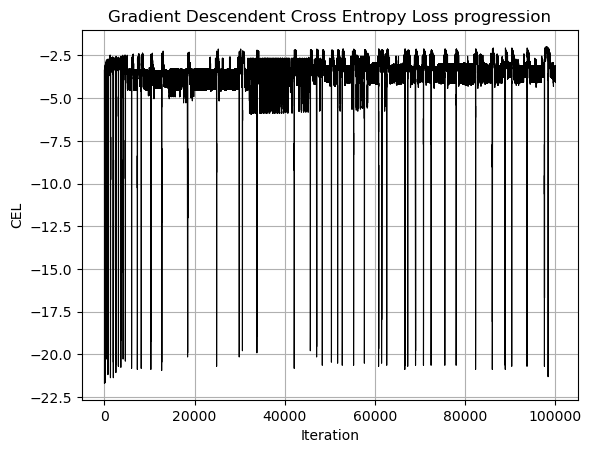

In [13]:
fig, ax = plt.subplots()

ax.set_title("Gradient Descendent Cross Entropy Loss progression")
ax.set_ylabel("CEL")
ax.set_xlabel("Iteration")

ax.plot(np.arange(len(cross_loss_list_gd_log)), cross_loss_list_gd_log, color='black', linewidth='0.8')
ax.grid(True)

plt.show()

B) Para cada modelo criado, reporte valor médio e desvio padrão da **acurácia global** e da **acurácia por classe**

In [14]:
def acc_log(x: np.ndarray, w:np.ndarray, y:np.ndarray):
    y_pred = log_func(x @ w)

    true_pos = ((y==1) & (y_pred == 1)).sum()
    true_neg = ((y==0) & (y_pred == 0)).sum()
    false_pos = ((y==0) & (y_pred == 1)).sum()
    false_neg = ((y==1) & (y_pred == 0)).sum()
    global_acc = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    class1_acc = true_pos / (true_pos + false_pos)
    class2_acc = true_neg / (true_neg + false_neg)

    return global_acc, class1_acc, class2_acc

In [15]:
acc_log(x_breastcancer_data, w_breastcancer_data_gd_log, y_breastcancer_data)

/var/folders/tc/mq592t7x67qbgfpvnk8cgrd80000gn/T/ipykernel_65042/745459150.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-value))


(0.9730848861283644, 0.9938271604938271, 0.9626168224299065)

### `SGD - Gradiente Descendente Estocástico`

In [16]:
# Gradiente descendente estocástico
def sgd(x: np.ndarray, y: np.ndarray, alpha: float = 0.001, max_epochs: int = 100, stopping_error: float = 1e-10):
    # Importando features e saídas
    X = x.copy()
    Y = y.copy()

    # Inicializando os pesos
    w_sgd = np.zeros((X.shape[1], 1))

    errors_list_sgd = np.empty((max_epochs * X.shape[0], X.shape[0]))
    mse_list_sgd = np.empty((max_epochs * X.shape[0], 1))

    # Gradiente descendente estocástico
    for epoch in range(max_epochs):
        # Permutando dados (entradas e saídas)
        XY = np.hstack((X, Y))
        XY = np.random.permutation(XY)
        X = XY[:, :-1]
        Y = XY[:, [-1]]

        for entry in range(X.shape[0]):
            # Calculando o erro
            pred_sgd = X[entry] @ w_sgd
            error_sgd = Y[entry] - pred_sgd
            
            w_sgd[0] = w_sgd[0] + alpha * error_sgd
            w_sgd[1:] = w_sgd[1:] + alpha * (X[entry,[1]].T * error_sgd)

            # Calculando o MSE e registrando o MSE e os Erros
            errors_list_sgd[[epoch * X.shape[0] + entry], :] = error_sgd.reshape(1, -1)
            mse_list_sgd[epoch * X.shape[0] + entry] = mse_gd(X, w_sgd, Y)

            # Parar caso o erro esteja abaixo do mínimo aceitável
            # if(mse < stopping_error):
            #     print(f'SGD encerrado precocemente pois os erros estão baixos o suficiente')
            #     break
    
    return w_sgd, mse_gd(X, w_sgd, y), errors_list_sgd, mse_list_sgd

In [17]:
w_breastcancer_data_sgd, mse_breastcancer_data_sgd, errors_list_sgd, mse_list_sgd = sgd(x_breastcancer_data, y_breastcancer_data, alpha= 0.01, max_epochs=60)

NameError: name 'mse_gd' is not defined

#### Parâmetros do modelo e **MSE (Erro Quadrático Médio)** final obitidos pelo algoritmo

In [ ]:
w_breastcancer_data_sgd

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [ ]:
mse_breastcancer_data_sgd

nan

#### Plote da curva de aprendizagem

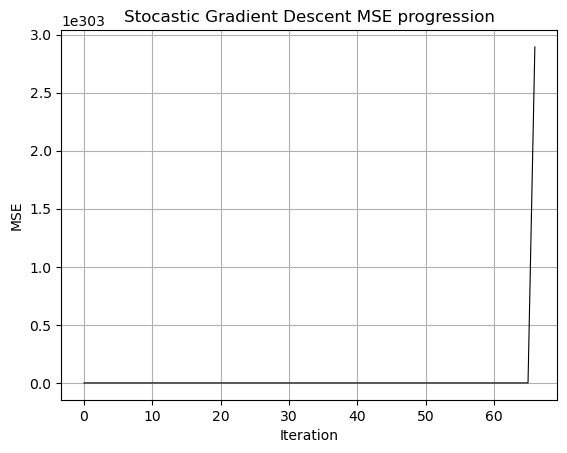

In [ ]:
fig, ax = plt.subplots()

ax.set_title("Stocastic Gradient Descent MSE progression")
ax.set_ylabel("MSE")
ax.set_xlabel("Iteration")

ax.plot(np.arange(mse_list_sgd.shape[0]), mse_list_sgd, color='black', linewidth='0.8')
ax.grid(True)

plt.show()

In [ ]:
def normalize_dataset_minmax(x: np.ndarray, y: np.ndarray):
    x_columns_max = x.max(axis=0)
    ymax = y.max()
    
    x_columns_min = x.min(axis=0)
    ymin = y.min()

    x = (x - x_columns_min) / (x_columns_max - x_columns_min)
    y = (y - ymin) / (ymax - ymin)

    # Valores necessários para a desnormalização
    xscale_tuple = (x_columns_max - x_columns_min, x_columns_min)
    yscale_tuple = (ymax - ymin, ymin)
    
    return x, y, xscale_tuple, yscale_tuple

def denormalize_dataset_minmax(x: np.ndarray, y: np.ndarray, xscale: Tuple[np.ndarray, np.ndarray], yscale: Tuple[float, float]):
    y = y * yscale[0] + yscale[1]
    x = x * xscale[0] + xscale[1]

    return x, y

def normalize_dataset_zscore(x: np.ndarray, y: np.ndarray):
    return 

def denormalize_dataset_zscore(x: np.ndarray, y: np.ndarray, scale: float):
    return 

In [ ]:
def split_train_test(x: np.ndarray, y: np.ndarray, split: float):
    # Checar valor do split
    if not (0.0 <= split <= 1.0):
        raise ValueError("O valor de split deve ser de 0 à 1")
    
    # Permuta os dados
    xy = np.random.permutation(np.hstack((x, y)))

    # Divide os dados entre treino e teste
    split_index = int(np.rint(xy.shape[0] * split))
    train = xy[:split_index, :]
    test = xy[split_index:, :]

    return train, test